In [1]:
from data import datasets

quick_draw_dataset = datasets.QuickDrawDataset()
num_images_to_generate = 100000
data_splits = [0.7, 0.2, 0.1]
for i, mode in enumerate(['train', 'val', 'test']):
    datasets.create_composite_dataset((int)(num_images_to_generate * data_splits[i]), mode, quick_draw_dataset)

In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import json
from detectron2.data import DatasetCatalog, MetadataCatalog
from data import datasets

dir = 'dataset/composite/'
classes = json.load(open(os.path.join(dir, 'train/labels.json')))

def get_dataset(mode):
    filename = os.path.join(dir, mode + '/data.json')
    with open(filename) as f:
        return json.load(f)

for d in ["train", "val", "test"]:
    DatasetCatalog.register("composite_" + d, lambda d=d: get_dataset(d))
    MetadataCatalog.get("composite_" + d).set(thing_classes=classes)
composite_metadata = MetadataCatalog.get("composite_train")

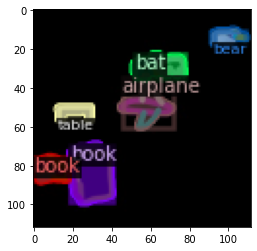

In [3]:
import random
import cv2
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt

dataset_dicts = DatasetCatalog.get("composite_train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=composite_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])

In [4]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
import torch

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("composite_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.MAX_ITER = 10000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
cfg.NUM_CLASSES = len(classes)
cfg.INPUT.MASK_FORMAT = "bitmask"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/06 08:24:49 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [5]:
from detectron2.engine import DefaultPredictor
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("composite_val", )
predictor = DefaultPredictor(cfg)

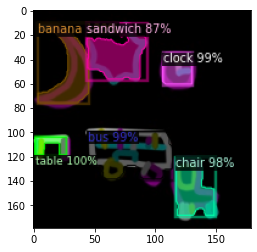

In [6]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_dataset("val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=composite_metadata, 
                   scale=0.8
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1])

In [8]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("composite_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "composite_val")
inference_on_dataset(trainer.model, val_loader, evaluator)


[06/06 17:40:54 d2.data.datasets.coco]: Converting annotations of dataset 'composite_val' to COCO format ...)
[06/06 17:40:55 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[06/06 17:41:02 d2.data.datasets.coco]: Conversion finished, #images: 20000, #annotations: 99494
[06/06 17:41:02 d2.data.datasets.coco]: Caching COCO format annotations at './output/composite_val_coco_format.json' ...
[06/06 17:41:08 d2.data.build]: Distribution of instances among all 52 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|  baseball  | 1757         |   knife    | 2259         |    car     | 2429         |
|    sink    | 2738         |  umbrella  | 1684         |    cat     | 1632         |
|  scissors  | 1568         |   train    | 1673         |   clock    | 1578         |
|    cow     | 1622         |   truck    | 1761         |    oven    | 2747  

OrderedDict([('bbox',
              {'AP': 69.4387179865424,
               'AP50': 84.37537239853418,
               'AP75': 81.42625940460604,
               'APs': 53.70476764364033,
               'APm': 71.93135444561989,
               'APl': 46.530491470926876,
               'AP-baseball': 78.9111009609335,
               'AP-knife': 59.04630957477561,
               'AP-car': 74.33578831582119,
               'AP-sink': 77.63200003026208,
               'AP-umbrella': 85.53170868362294,
               'AP-cat': 66.38601380414018,
               'AP-scissors': 72.45181354757393,
               'AP-train': 55.73927864732554,
               'AP-clock': 85.81460344985491,
               'AP-cow': 60.03747292799311,
               'AP-truck': 59.454786498949275,
               'AP-oven': 66.20904790955288,
               'AP-carrot': 74.80034459123502,
               'AP-toothbrush': 61.57633901195511,
               'AP-table': 63.42018405203379,
               'AP-fork': 65.86479